## Advance Lane Line Detection

In [1]:
%%HTML
<style> code {background-color : pink !important;} </style>

### Camera Calibration
***I used various calibration images to compute image and object points.***

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'output_images/calib_op/corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

###  We have got `objpoints` and `imgpoints` needed for camera calibration.  Below is the code for calculation of calibration matrix and distortion coeficients.

In [ ]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open("output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### Image processing Pipeline

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import pickle
%matplotlib inline

**Load Camera Calibration matrix and distortion coeficients**

In [3]:
with open("output_images/wide_dist_pickle.p","rb") as f:
     dist_pickle = pickle.load(f)
        
mtx, dist = dist_pickle['mtx'], dist_pickle['dist']
print("Loaded calibration matrix and distortion coeficients !!!")
print()
print("Calibration Matrix:")
print()
print(mtx)
print()
print("Distortion Coeficients:")
print()
print(dist)



Loaded calibration matrix and distortion coeficients !!!

Calibration Matrix:

[[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

Distortion Coeficients:

[[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


***Supporting Functions***

In [4]:
def corners_unwarp(img):
    '''Function to apply perspective transform
       Input :- Image 
       Output :- Warped Image, perpective transform matrix, inverse transform matrix
    '''
    img_size = (img.shape[1], img.shape[0])
    color=[255, 0, 0] 
    thickness=8
    #src points
    top_left = [585,455]
    top_right = [690,455]
    bottom_right = [1130,720]
    bottom_left = [240,720]
    #dest points
    top_left_dst = [320,0]
    top_right_dst = [990,0]
    bottom_right_dst = [990,720]
    bottom_left_dst = [320,720]
    src = np.float32([bottom_left,top_left,top_right,bottom_right])
    dest = np.float32([bottom_left_dst,top_left_dst,top_right_dst,bottom_right_dst])    
    M = cv2.getPerspectiveTransform(src, dest)
    Minv = cv2.getPerspectiveTransform(dest, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped,M,Minv

def noise_reduction(image, threshold=4):
    '''Function to eliminate noide
       Input :- Image, threshold 
       Output :- Noise eliminated image
    '''
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(image, ddepth=-1, kernel=k)
    image[nb_neighbours < threshold] = 0
    return image

def create_binary(img, gray_thresh=(20, 255), s_thresh=(170, 255), l_thresh=(30, 255), luv_l_thresh=(210, 255),sobel_kernel=3,lab_b_thresh=(160, 255)):
    '''Function to apply gradient and color thresholding and create binary image'''
    ksize =9
    undistort_warp = np.copy(img)
    imhls = cv2.cvtColor(undistort_warp, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = imhls[:,:,0]
    L = imhls[:,:,1] 
    S = imhls[:,:,2]
    # 3) Return a binary image of threshold result
    s_binary_output = np.zeros_like(S)
    s_binary_output[(S >= s_thresh[0]) & (S <= s_thresh[1])] = 1
    #l_binary_output = np.zeros_like(L)
    #l_binary_output[(L >= l_thresh[0]) & (L <= l_thresh[1])] = 1     
    
    #Apply sobel on L channel in x direction
    sobelx = cv2.Sobel(L, cv2.CV_64F, 1, 0,ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    lxbinary = np.zeros_like(scaled_sobel)
    lxbinary[(scaled_sobel >= gray_thresh[0]) & (scaled_sobel <= gray_thresh[1])] = 1
    
    imluv = cv2.cvtColor(undistort_warp, cv2.COLOR_RGB2LUV)
    luv_L = imluv[:,:,0]
    luv_U = imluv[:,:,1] 
    luv_V = imluv[:,:,2]
    # 3) Return a binary image of threshold result
    luv_L_binary_output = np.zeros_like(luv_L)
    luv_L_binary_output[(luv_L >= luv_l_thresh[0]) & (luv_L <= luv_l_thresh[1])] = 1
    
    imlab = cv2.cvtColor(undistort_warp, cv2.COLOR_RGB2LAB)
    lab_L = imlab[:,:,0]
    lab_A = imlab[:,:,1] 
    lab_B = imlab[:,:,2]
    # 3) Return a binary image of threshold result
    lab_B_binary_output = np.zeros_like(lab_B)
    lab_B_binary_output[(lab_B >= lab_b_thresh[0]) & (lab_B <= lab_b_thresh[1])] = 1
        
    combined = np.zeros_like(lab_B_binary_output)
    #Grad x + S channel
    #combined[(lxbinary == 1) | ((s_binary_output == 1) & (l_binary_output == 1) & (luv_L_binary_output == 1))|(lab_B_binary_output==1)] = 1
    combined[(lxbinary == 1) | ((s_binary_output == 1) & (luv_L_binary_output == 1))|(lab_B_binary_output==1)] = 1
    
    #unwarp binary image
    #combined = 255 * np.dstack((combined, combined, combined)).astype('uint8')
    return noise_reduction(combined)

class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        self.left_fit = None
        self.right_fit = None

        self.MAX_BUFFER_SIZE = 12

        self.buffer_index = 0
        self.iter_counter = 0

        self.buffer_left = np.zeros((self.MAX_BUFFER_SIZE, 720))
        self.buffer_right = np.zeros((self.MAX_BUFFER_SIZE, 720))

    def lane_detector(self,binary_warped):
        '''Function to apply sliding window on image and detect lane
        '''
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Set the width of the windows +/- margin
        margin = 75
        # Create an output image to draw on and  visualize the result
        #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Set minimum number of pixels found to recenter window
        minpix = 30
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            #Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
            
        # Extract left and right line pixel position
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        self.detected=True
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = self.left_fit[0] * ploty ** 2 + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = self.right_fit[0] * ploty ** 2 + self.right_fit[1] * ploty + self.right_fit[2]
        return left_fitx, right_fitx
    
    def smart_lane_detector(self,binary_warped):
        '''Function to detect lanes using history lane alignment information'''
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Set the width of the windows +/- margin
        margin = 75
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
        left_fitx = self.left_fit[0] * ploty ** 2 + self.left_fit[1] * ploty + self.left_fit[2]
        right_fitx = self.right_fit[0] * ploty ** 2 + self.right_fit[1] * ploty + self.right_fit[2]
        return left_fitx, right_fitx


    def radias_curvature(self,image_shape,leftx,rightx):
        '''Function to calculate radius of curvature and vehicle position'''
        #Calclulate 'x' at bottom of both lanes. 
        left_bottomx = self.left_fit[0] * image_shape[0] ** 2 + self.left_fit[1] * image_shape[0] + self.left_fit[2]
        right_bottomx = self.right_fit[0] * image_shape[0] ** 2 + self.right_fit[1] * image_shape[0] + self.right_fit[2]
        #Calculate road width
        road_width = right_bottomx - left_bottomx
        
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)        
        
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/image_shape[0] # meters per pixel in y dimension
        xm_per_pix = 3.7/road_width # meters per pixel in x dimension
        
    
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        #Calculate distnace of vehicle from center of lane
        center_of_lane_x = (right_bottomx - left_bottomx)/2 + left_bottomx
        center_of_image_x = image_shape[1]/2
        vehicle_pos = (center_of_lane_x - center_of_image_x) * xm_per_pix
        
        return left_curverad,right_curverad,vehicle_pos
     
    def process_image(self,img):
        '''Function to apply image pipeline'''
        img = np.copy(img)
        
        #undistort image
        undistort_img = cv2.undistort(img, mtx, dist, None, mtx)
        
        #perspective Transform
        warped,M,Minv = corners_unwarp(undistort_img)
        
        #Binary creation after applying color and gradient threshold
        binary_warped = create_binary(warped)
        
        #Check if it's first frame and if yes use sliding window
        if(self.detected):
            left_fitx,right_fitx = self.smart_lane_detector(binary_warped)
        else:
            left_fitx,right_fitx= self.lane_detector(binary_warped)
        
        #Calculate average of line detections from last 12 frames 
        self.buffer_left[self.buffer_index] = left_fitx
        self.buffer_right[self.buffer_index] = right_fitx

        self.buffer_index += 1
        self.buffer_index %= self.MAX_BUFFER_SIZE
        
        if self.iter_counter < self.MAX_BUFFER_SIZE:
            self.iter_counter += 1
            ave_left = np.sum(self.buffer_left, axis=0) / self.iter_counter
            ave_right = np.sum(self.buffer_right, axis=0) / self.iter_counter
        else:
            ave_left = np.average(self.buffer_left, axis=0)
            ave_right = np.average(self.buffer_right, axis=0)
        
        #Calculate  radius of curvature and Vehicle Position
        l_rad_curv,r_rad_curv,vehicle_pos  = self.radias_curvature(img.shape,ave_left,ave_right)
        
        
        #create blank image to draw lane
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        copy_image = np.zeros_like(img)
        ploty = np.linspace(0, copy_image.shape[0] - 1, copy_image.shape[0])
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([ave_left, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([ave_right, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        
        # Combine the result with the original image
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(undistort_img, 'Radius of curvature (Left)  = %.2f m' % (l_rad_curv), (10, 40), font, 1,(221, 28, 119), 2, cv2.LINE_AA)
        cv2.putText(undistort_img, 'Radius of curvature (Right) = %.2f m' % (r_rad_curv), (10, 70), font, 1,(221, 28, 119), 2, cv2.LINE_AA)
        cv2.putText(undistort_img, 'Vehicle position : = %.2f m of center' % (vehicle_pos), (10, 100), font, 1, (221, 28, 119), 2, cv2.LINE_AA)
        result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)
        return result
    


### Image Transformation on Test Image

***Loaded Test Image and applied undistort***

In [5]:
img = mpimg.imread('test_images/test3.jpg')

undistort_img = cv2.undistort(img, mtx, dist, None, mtx)

***Applied Perspective transform***

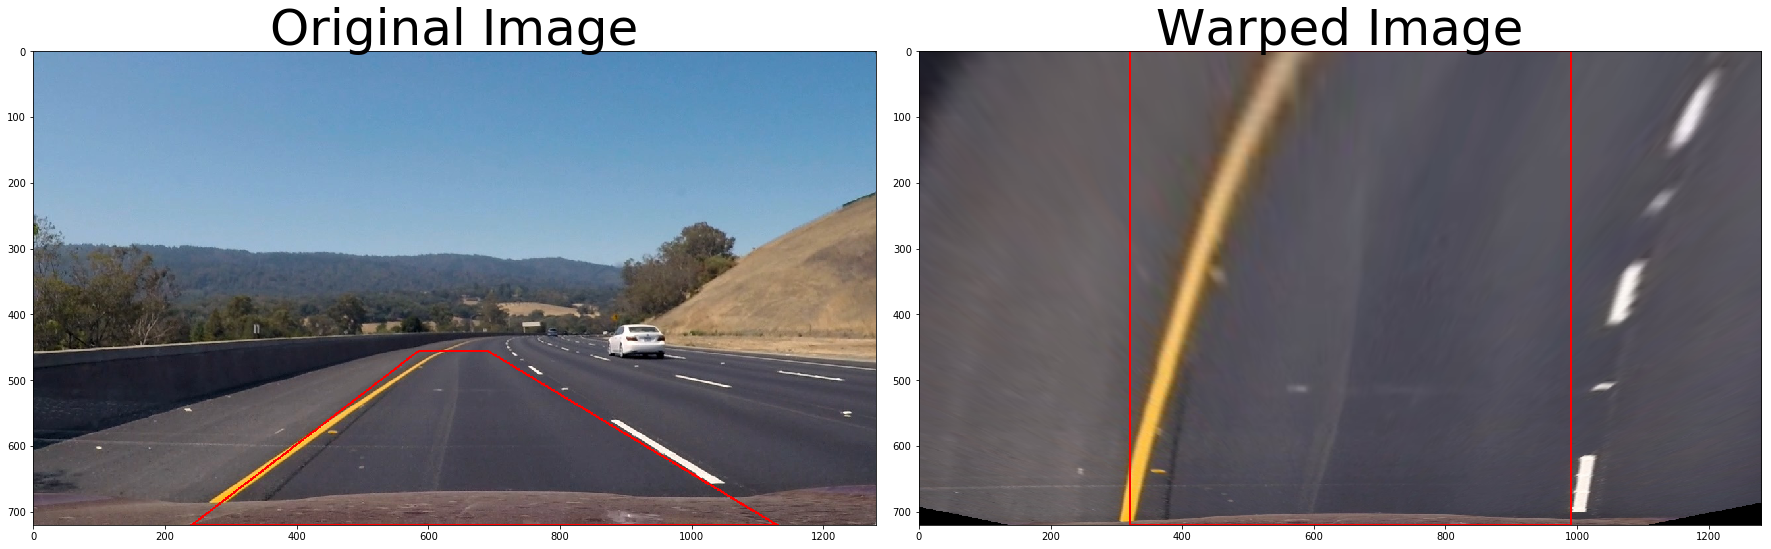

In [6]:
img_copy = img.copy()
cv2.line(img_copy, (240 , 720), (585,455), color=[255,0,0], thickness=2)
cv2.line(img_copy, (585,455), (690,455), color=[255,0,0], thickness=2)
cv2.line(img_copy, (690,455), (1130,720), color=[255,0,0], thickness=2)
cv2.line(img_copy, (1130,720), (240 , 720), color=[255,0,0], thickness=2)

warped,M,Minv = corners_unwarp(undistort_img)

warped_copy= warped.copy()
cv2.line(warped_copy, (320 , 720), (320 , 0), color=[255,0,0], thickness=2)
cv2.line(warped_copy, (320 , 0), (990 , 0), color=[255,0,0], thickness=2)
cv2.line(warped_copy, (990 , 0), (990 , 720), color=[255,0,0], thickness=2)
cv2.line(warped_copy, (990 , 720), (320 , 720), color=[255,0,0], thickness=2)
plt.imsave('output_images/test3_warped_marking.jpg', warped_copy, cmap=cm.gray)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_copy)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped_copy, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

***Create Binary Image by applying gradient and color thresholds***

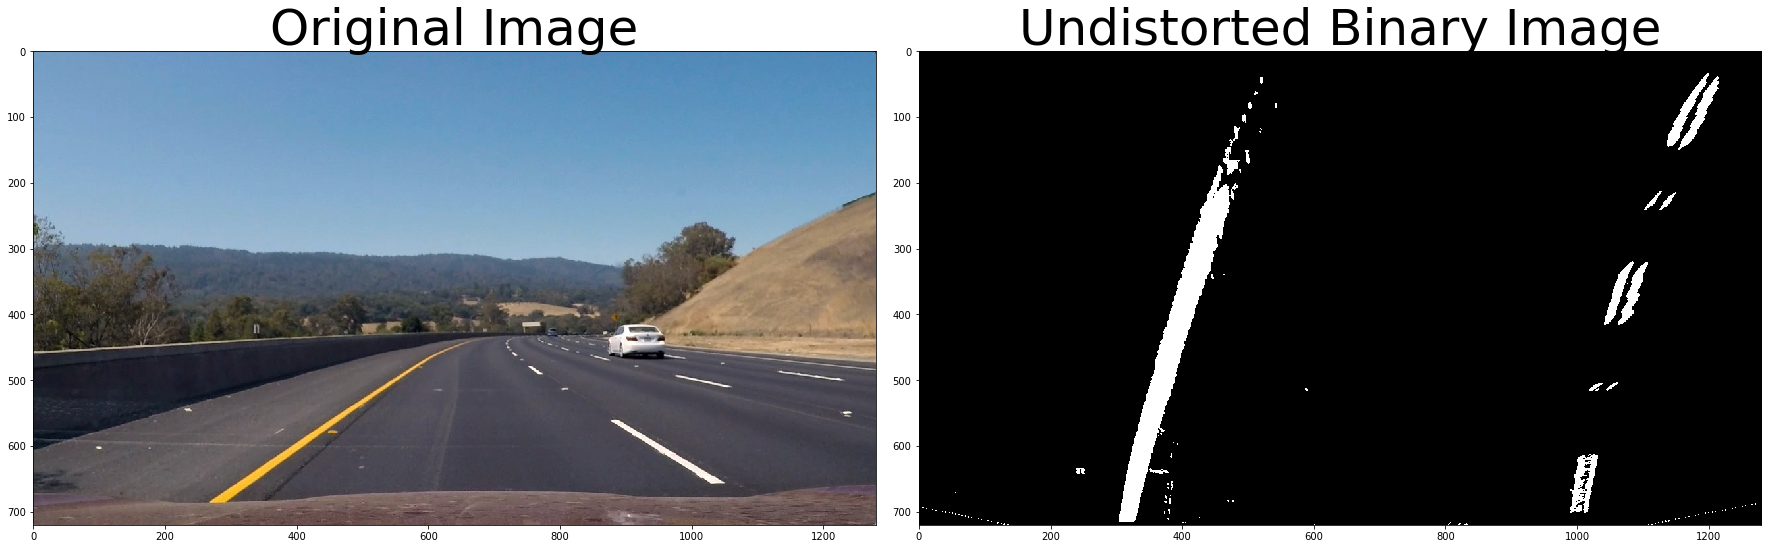

In [7]:
binary_warped = create_binary(warped)
#binary_warped = create_binary(undistort_img)
#plt.imsave('output_images/test3_binary_warped.jpg', binary_warped, cmap=cm.gray)
#Perspective transform
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('Undistorted Binary Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



***Lane Detection - Applied slinding window to find lanes***

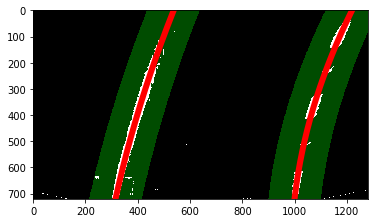

In [8]:

test_line = Line()
left_fitx,right_fitx = test_line.lane_detector(binary_warped)
left_fitxx=left_fitx.astype(np.int64)
right_fitxx=right_fitx.astype(np.int64)
margin = 100
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
ploty=ploty.astype(np.int64)
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))
out_img[ploty, left_fitxx] = [255, 0, 0]
out_img[ploty, right_fitxx] = [0, 0, 255]
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result_lane = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.imshow(result_lane,cmap='gray')
plt.plot(left_fitx, ploty, color='red',linewidth=6.0)
plt.plot(right_fitx, ploty, color='red',linewidth=6.0)
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.imsave('output_images/test3_lanedrawing_raw.jpg', result_lane)

***Calculated Radius of Curvature and Vehicle Position***

In [9]:
l_rad_curv,r_rad_curv,vehicle_pos  = test_line.radias_curvature(img.shape,left_fitx,right_fitx)
#Vehicle Position

warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

copy_image = np.zeros_like(img)
ploty = np.linspace(0, copy_image.shape[0] - 1, copy_image.shape[0])

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(undistort_img, 'Radius of curvature (Left)  = %.2f m' % (l_rad_curv), (10, 40), font, 1,(221, 28, 119), 2, cv2.LINE_AA)
cv2.putText(undistort_img, 'Radius of curvature (Right) = %.2f m' % (r_rad_curv), (10, 70), font, 1,(221, 28, 119), 2, cv2.LINE_AA)
cv2.putText(undistort_img, 'Vehicle position : = %.2f m of center' % (vehicle_pos), (10, 100), font, 1, (221, 28, 119), 2, cv2.LINE_AA)
result = cv2.addWeighted(undistort_img, 1, newwarp, 0.3, 0)

***Final step - Lanes drawn on orignal Image***

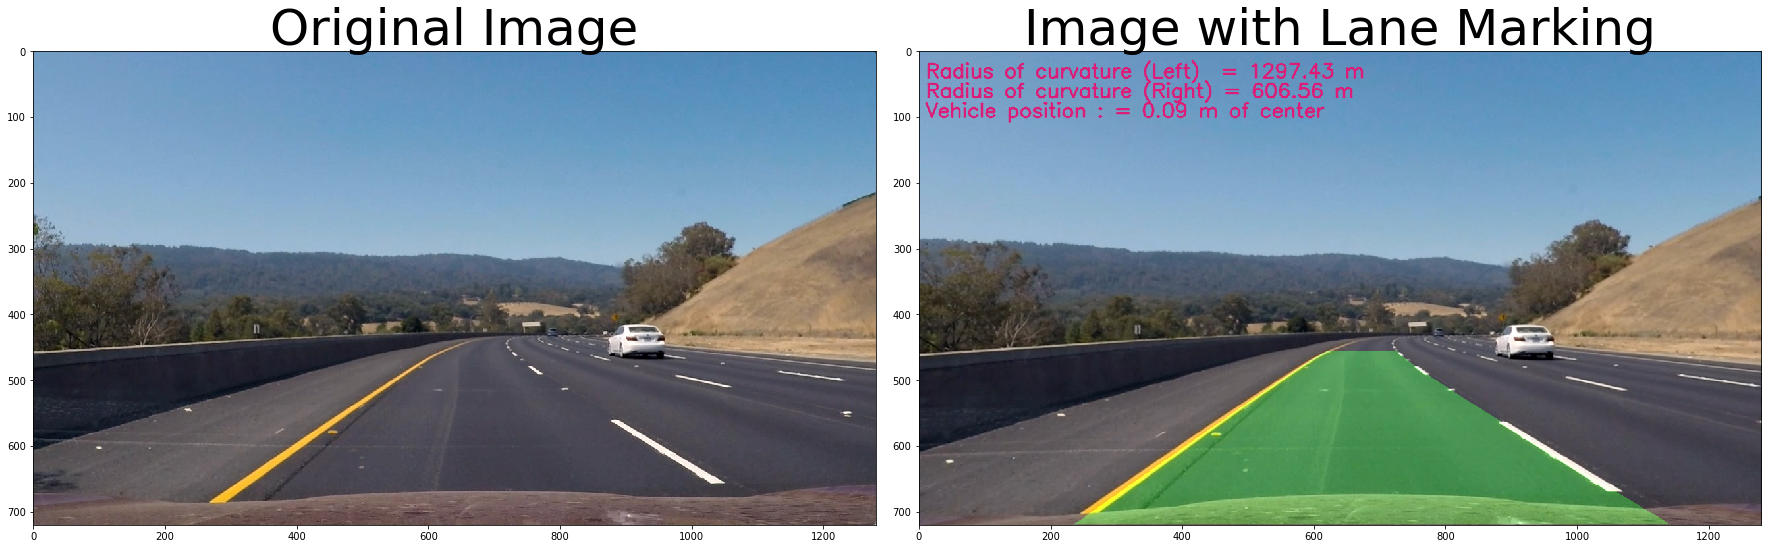

In [10]:
plt.imsave('output_images/test3_finallane_marking.jpg', result, cmap=cm.gray)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result)
ax2.set_title('Image with Lane Marking', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Image Transformation on  Project Video

***Load Video and apply pipeline function -process_image() to each frame***

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
line = Line()

In [12]:
white_output ='challenge_solved.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(line.process_image) #NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_solved.mp4
[MoviePy] Writing video challenge_solved.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 485/485 [01:36<00:00,  5.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_solved.mp4 



***Play Output Video***

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))